In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
import random
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
from itertools import product
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord  # High-level coordinates
from astropy.coordinates import ICRS, Galactic, FK4, FK5
from astropy.coordinates import Angle, Latitude, Longitude  # Angles
import astropy.units as u
import math
import re
import cv2

In [2]:
len(glob.glob('/data/scratch/sarperyurtseven/dataset/NIRCAM/1386/injections/fc5_injections_train/*fc5.npy'))

54905

In [3]:
len(glob.glob('/data/scratch/sarperyurtseven/dataset/NIRCAM/1386/injections/fc5_injections_train/*[!fc5].npy'))

48260

In [4]:
def get_wcs(fits):
    return WCS(fits[1].header, naxis=2)

def get_ra_dec(fits):
    ra  = fits[0].header['TARG_RA']
    dec = fits[0].header['TARG_DEC'] 
    return ra, dec

def get_skycoord(ra, dec):
    ra = Longitude(ra, unit=u.deg)
    dec = dec * u.deg
    sky_coord = SkyCoord(ra, dec, frame='icrs')
    sky_coord = SkyCoord(frame=ICRS, ra=ra, dec=dec)
    return sky_coord

def skycoord_to_pixel(wcs,skycoord):
    x, y = wcs.world_to_pixel(skycoord)
    return  y, x 

In [5]:
def rotate_point(x, y, angle_degrees, center=(40, 40)):
    # Convert angle to radians
    angle_radians = math.radians(angle_degrees)

    # Calculate the distance from the center to the point
    dx = x - center[0]
    dy = y - center[1]

    # Rotate the point
    new_x = center[0] + dx * math.cos(angle_radians) + dy * math.sin(angle_radians)
    new_y = center[1] - dx * math.sin(angle_radians) + dy * math.cos(angle_radians)

    return new_x, new_y


def flip_point(x, y, flipud:bool, fliplr:bool):

    h, w = 80, 80


    if flipud and fliplr:
        new_x = h - 1 - x 
        new_y = w - 1 - y  

    elif (flipud == True) and (fliplr == False):
        new_x = w - 1 - x  
        new_y = y #w - 1 - y  

    elif (flipud == False) and (fliplr == True):
        new_x = x  
        new_y = h - 1 - y 

    else:
        new_x, new_y = x, y


    return new_x, new_y


def find_new_coordinates_after_shift(original_x, original_y, right_shift, down_shift):
    h, w = 80, 80
    new_x = (original_x + right_shift) % h
    new_y = (original_y + down_shift) % w
    return new_x, new_y

def calculate_distance(x1, y1, x2, y2):
    
    return math.sqrt((x2 - x1)**2 + (y2 - y1)**2)

def get_augmentation_info(info):

    infos = []
    for inf in info:  

        numeric_info = []
        for lst in inf.split('/')[-1].split('-')[6:-3]:

            numeric_info.append(re.findall(r'\d+', lst)[0])

        infos.append(numeric_info)

    return infos

In [6]:
def get_psf_info(injection_dirs):

    #root_dir = "/data/scratch/bariskurtkaya/dataset/NIRCAM/1386/mastDownload/JWST/"
    root_dir = "/data/scratch/sarperyurtseven/dataset/NIRCAM/1386/mastDownload/JWST/"
    sew = set()
    star_location_info = []
    for i in range(len(injection_dirs)):
        
        psf_name = '-'.join(injection_dirs[i].split('/')[-1].split('-')[:4]) + '_psfstack.fits'

        complete_dirs = os.path.join(root_dir, psf_name)
        psf_ = fits.open(complete_dirs)
        wcs = get_wcs(psf_)
        ra, dec = get_ra_dec(psf_)
        sew.add((ra,dec))
        sky_coord = get_skycoord(ra, dec)
        x, y = skycoord_to_pixel(wcs, sky_coord)
        star_location_info.append((x,y))
        
    return star_location_info


In [7]:
def do_transformations(infos, locations):

    transformed_list = []
    for idx, info in enumerate(infos):

        if len(info) == 6:

            y = 54-4#int(locations[idx][0]) 
            x = 36-5#int(locations[idx][1])

            rotate     = int(info[0])
            flip       = int(info[1])
            vertical   = int(info[2])
            horizontal = int(info[3])
            vshift     = int(info[4])
            hshift     = int(info[5])

            x, y = rotate_point(x, y, rotate*90)

            x, y = flip_point(x, y, flipud=True if flip == 1 or flip == 3 else False, fliplr=True if flip == 2 or flip == 3 else False)
            x, y = find_new_coordinates_after_shift(x, y, right_shift=hshift if horizontal == 2 else -hshift, down_shift=vshift if vertical == 2 else -vshift)

            transformed_list.append((int(x), int(y)))

        else:
            y = 54#int(locations[idx][0]) 
            x = 36#int(locations[idx][1])
            transformed_list.append((y, x))

    return transformed_list

In [8]:
def get_array(nps):

    arrays = []

    for arr in nps[:25]:

        img = np.load(arr)
        arrays.append(img)

    arrays = np.concatenate(np.expand_dims(arrays, axis=0))

    return arrays        

In [9]:
def apply_low_pass(array):

    if len(array.shape) == 2:
    
        r = 50
        ham = np.hamming(80)[:,None] 
        ham2d = np.sqrt(np.dot(ham, ham.T)) ** r 
        f = cv2.dft(array.astype(np.float32), flags=cv2.DFT_COMPLEX_OUTPUT)
        f_shifted = np.fft.fftshift(f)
        f_complex = f_shifted[:,:,0]*1j + f_shifted[:,:,1]
        f_filtered = ham2d * f_complex
        f_filtered_shifted = np.fft.fftshift(f_filtered)
        inv_img = np.fft.ifft2(f_filtered_shifted) 
        filtered_img = np.abs(inv_img)
        filtered_img -= filtered_img.min()
        filtered_img = filtered_img*255 / filtered_img.max()
        filtered_img = filtered_img.astype(np.uint8)
        output = filtered_img

    elif len(array.shape) == 3:

        output = []
        r = 50 
        ham = np.hamming(80)[:,None] 
        ham2d = np.sqrt(np.dot(ham, ham.T)) ** r 

        for i in range(array.shape[0]):

            f = cv2.dft(array[i].astype(np.float32), flags=cv2.DFT_COMPLEX_OUTPUT)
            f_shifted = np.fft.fftshift(f)
            f_complex = f_shifted[:,:,0]*1j + f_shifted[:,:,1]
            f_filtered = ham2d * f_complex
            f_filtered_shifted = np.fft.fftshift(f_filtered)
            inv_img = np.fft.ifft2(f_filtered_shifted) 
            filtered_img = np.abs(inv_img)
            filtered_img -= filtered_img.min()
            filtered_img = filtered_img*255 / filtered_img.max()
            filtered_img = filtered_img.astype(np.uint8)
            output.append(filtered_img)
        
        output = np.concatenate(np.expand_dims(output, axis=0))


    return output

In [10]:
train_arrays = glob.glob('/data/scratch/sarperyurtseven/dataset/NIRCAM/1386/injections/fc5_injections_train/*fc5.npy')[:25]
#random.shuffle(train_arrays)

In [11]:
locations        = get_psf_info(train_arrays[:25])
info             = get_augmentation_info(train_arrays[:25])
transformed_list = do_transformations(info, locations)
arrays           = get_array(train_arrays[:25])

Set OBSGEO-B to    16.052288 from OBSGEO-[XYZ].
Set OBSGEO-H to 1528813205.103 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -35.252286 from OBSGEO-[XYZ].
Set OBSGEO-H to 1706760253.307 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -35.230546 from OBSGEO-[XYZ].
Set OBSGEO-H to 1706565464.343 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -35.249661 from OBSGEO-[XYZ].
Set OBSGEO-H to 1706736692.634 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -35.234025 from OBSGEO-[XYZ].
Set OBSGEO-H to 1706596592.593 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Distance: 9.219544457292887
Distance: 13.152946437965905
Distance: 17.69180601295413
Distance: 27.85677655436824
Distance: 28.844410203711913
Distance: 5.385164807134504
Distance: 2.23606797749979
Distance: 14.142135623730951
Distance: 27.65863337187866
Distance: 15.524174696260024
Distance: 27.313000567495326
Distance: 1.0
Distance: 12.727922061357855
Distance: 22.090722034374522
Distance: 16.1245154965971
Distance: 18.027756377319946
Distance: 11.180339887498949
Distance: 16.15549442140351
Distance: 17.0
Distance: 20.12461179749811
Distance: 5.0
Distance: 10.198039027185569
Distance: 25.298221281347036
Distance: 5.0
Distance: 9.433981132056603


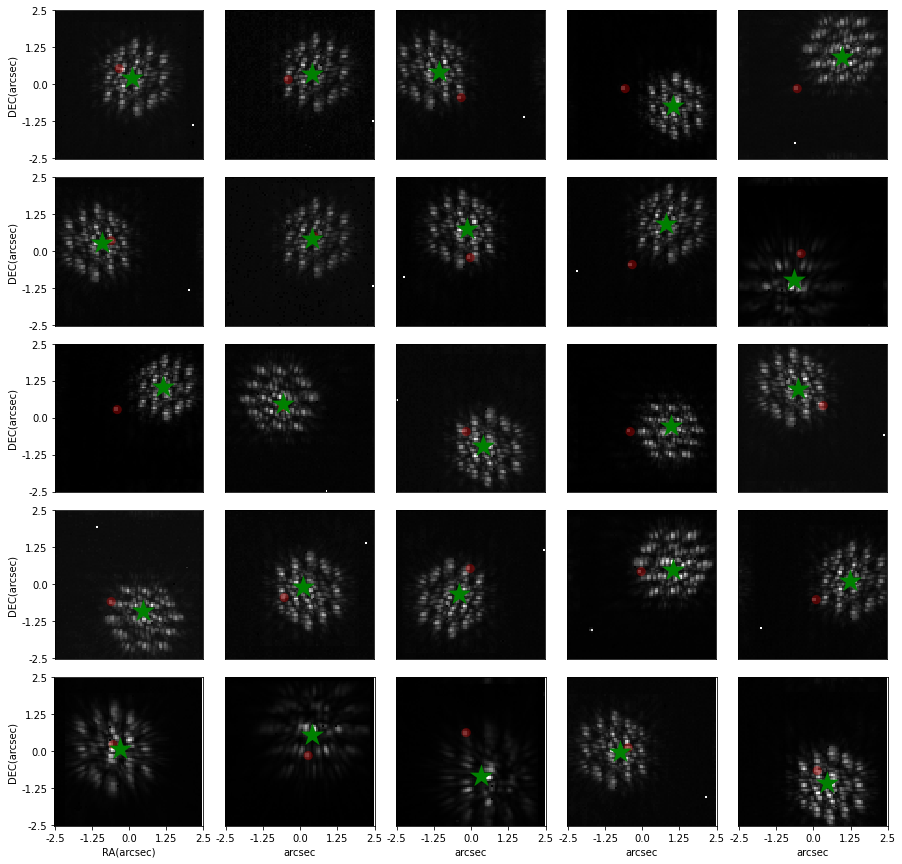

In [17]:
bs = 5
nrows = 5
fig, axes = plt.subplots(nrows=nrows,ncols=bs,figsize=(15,15))

step = 20*0.06259530358142339
step = round(step,2)
labels = step*np.array([-2., -1., 0., 1., 2.])
axis_points = np.linspace(0,80,5)

for i, (row,col) in enumerate(product(range(nrows),range(bs))):

    idx_x  = train_arrays[i].rfind('x')

    if idx_x == -1:
        x, y = 0, 0
    else:
        x = int(train_arrays[i][idx_x+1:idx_x+3])
        y = int(train_arrays[i][idx_x+5:idx_x+7])

    #x, y = int(train_arrays[i].split('/')[-1].split('-')[-3:-1][0][1:]), int(train_arrays[i].split('/')[-1].split('-')[-3:-1][1][1:])
    axes[row][col].imshow(arrays[i], interpolation='nearest', cmap='Greys_r')

    if col == 0:
        axes[row][col].set_yticks(axis_points,labels, fontsize=10, rotation=0)
        axes[row][col].set_ylabel('DEC(arcsec)', fontsize=10)
        
        if row == 4:
            axes[row][col].set_xticks(axis_points,labels, fontsize=10, rotation=0)
            axes[row][col].set_xlabel('RA(arcsec)', fontsize=10)

        else:
            axes[row][col].set_xticks([])

    elif row == 4:
        axes[row][col].set_xticks(axis_points,labels, fontsize=10, rotation=0)
        axes[row][col].set_xlabel('arcsec', fontsize=10)
        axes[row][col].set_yticks([])

    else:
        axes[row][col].set_yticks([])
        axes[row][col].set_xticks([])


    axes[row][col].text(x, y, s="\u25CF", fontsize=12, color='red', alpha=.3, ha='center', va='center')#u"\u2734"
    axes[row][col].invert_yaxis()

    
    if int(transformed_list[i][0]) == -1:
        pass
    else:
        axes[row][col].text(int(transformed_list[i][0]), int(transformed_list[i][1]) , s="\u2605", fontsize=30, color='green', ha='center', va='center')
    
    print("Distance:",calculate_distance(x1=x,x2=int(transformed_list[i][0]), y1=y,y2=int(transformed_list[i][1])))
    
plt.subplots_adjust(wspace=.12,hspace=.12)
plt.savefig('figure.jpg',format='jpg', dpi=300, bbox_inches='tight', pad_inches=.1)
plt.show()

In [ ]:
info

In [ ]:
no_inj = glob.glob('/data/scratch/sarperyurtseven/dataset/NIRCAM/1386/injections2/fc5_injections_train/*[!fc5].npy')[25:55]
no_inj_arrays = get_array(no_inj)

In [ ]:
no_ary = no_inj_arrays[0]

In [ ]:
no_farrays = apply_low_pass(arrays)

In [ ]:
bs = 5
nrows = 5
fig, axes = plt.subplots(nrows=nrows,ncols=bs,figsize=(15,15))

for i, (row,col) in enumerate(product(range(nrows),range(bs))):
    axes[row][col].imshow(no_farrays[i], interpolation='nearest', cmap='inferno')
    axes[row][col].set_yticks([])
    axes[row][col].set_xticks([])

plt.subplots_adjust(wspace=0,hspace=0)
plt.show()

In [ ]:
iary = apply_low_pass(ary)
no_iary = apply_low_pass(no_ary)
#iiary = apply_low_pass(iary)
#iiiary = apply_low_pass(iiary)

In [ ]:
plt.imshow(ary)

In [ ]:
plt.imshow(iary)

In [ ]:
plt.imshow(no_iary)

In [ ]:
train_arrays[:25]

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from itertools import product
from PIL import Image
import numpy as np
import glob
import os


In [ ]:
class SynDatasetLabel(Dataset):

    def __init__(self, image_paths):

        self.image_paths = image_paths
        self.transform = transforms.Compose([
        transforms.ToTensor(),
        ])

        pass

    def __len__(self):

        return len(self.image_paths)


    def __getitem__(self, index):
        
        image_path = self.image_paths[index]
        
        if 'fc1' in image_path.split('/')[-1]:
            
            label = 1.0
        else:
            label = 0.0

        image = np.load(image_path)
        image = self.transform(image)

        couple = (image, label)

        return couple

In [ ]:
train_paths = glob.glob(os.path.join('/data/scratch/bariskurtkaya/dataset/NIRCAM/1386/injections','fc1_injections_train/*.npy'))
print(len(train_paths))
test_paths = glob.glob(os.path.join('/data/scratch/bariskurtkaya/dataset/NIRCAM/1386/injections','fc1_injections_test/*.npy'))
print(len(test_paths))

syndata        = SynDatasetLabel(image_paths=train_paths)
syndata_loader = DataLoader(dataset=syndata, batch_size=1024, shuffle=False)

In [ ]:
idx, (image, label) = next(enumerate(syndata_loader))

In [ ]:
torch.sum(label)